# CNN. Practice
# Keras API

Source: 
- https://github.com/Hvass-Labs/TensorFlow-Tutorials
- https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ

## Introduction

The previous tutorial showed that a simple neural net had about 92% classification accuracy for recognizing hand-written digits in the MNIST data-set.

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.

![Flowchart](images/02_network_flowchart.png)

The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The images are also down-sampled so the image resolution is decreased from 28x28 to 14x14.

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are down-sampled again to 7x7 pixels.

The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons (or elements). This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured as the so-called cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

These particular filter-weights and intermediate images are the results of one optimization run and may look different if you re-run this Notebook.

Note that the computation in TensorFlow is actually done on a batch of images instead of a single image, which makes the computation more efficient. This means the flowchart actually has one more data-dimension when implemented in TensorFlow.

## Convolutional layer

The following chart shows the basic idea of processing an image in the first convolutional layer. The input image depicts the number 7 and four copies of the image are shown here, so we can see more clearly how the filter is being moved to different positions of the image. For each position of the filter, the dot-product is being calculated between the filter and the image pixels under the filter, which results in a single pixel in the output image. So moving the filter across the entire input image results in a new image being generated.

The red filter-weights means that the filter has a positive reaction to black pixels in the input image, while blue pixels means the filter has a negative reaction to black pixels.

In this case it appears that the filter recognizes the horizontal line of the 7-digit, as can be seen from its stronger reaction to that line in the output image.

![Convolution example](images/02_convolution.png)

The step-size for moving the filter across the input is called the stride. There is a stride for moving the filter horizontally (x-axis) and another stride for moving vertically (y-axis).

In the source-code below, the stride is set to 1 in both directions, which means the filter starts in the upper left corner of the input image and is being moved 1 pixel to the right in each step. When the filter reaches the end of the image to the right, then the filter is moved back to the left side and 1 pixel down the image. This continues until the filter has reached the lower right corner of the input image and the entire output image has been generated.

When the filter reaches the end of the right-side as well as the bottom of the input image, then it can be padded with zeroes (white pixels). This causes the output image to be of the exact same dimension as the input image.

Furthermore, the output of the convolution may be passed through a so-called Rectified Linear Unit (ReLU), which merely ensures that the output is positive because negative values are set to zero. The output may also be down-sampled by so-called max-pooling, which considers small windows of 2x2 pixels and only keeps the largest of those pixels. This halves the resolution of the input image e.g. from 28x28 to 14x14 pixels.

Note that the second convolutional layer is more complicated because it takes 16 input channels. We want a separate filter for each input channel, so we need 16 filters instead of just one. Furthermore, we want 36 output channels from the second convolutional layer, so in total we need 16 x 36 = 576 filters for the second convolutional layer. It can be a bit challenging to understand how this works.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from helpers import *

We need to import several things from Keras. Note the long import-statements. This might be a bug. Hopefully it will be possible to write shorter and more elegant lines in the future.

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'1.4.0'

In [4]:
tf.keras.__version__

'2.0.8-tf'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Plot a few images to see if data is correct

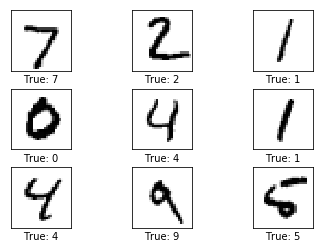

In [9]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, img_shape=img_shape)

## Sequential Model

The Keras API has two modes of constructing Neural Networks. The simplest is the Sequential Model which only allows for the layers to be added in sequence.

In [10]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28, 28, 1)
model.add(Reshape(img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax'))

### Model Compilation

The Neural Network has now been defined and must be finalized by adding a loss-function, optimizer and performance metrics. This is called model "compilation" in Keras.

We can either define the optimizer using a string, or if we want more control of its parameters then we need to instantiate an object. For example, we can set the learning-rate.

In [11]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

For a classification-problem such as MNIST which has 10 possible classes, we need to use the loss-function called `categorical_crossentropy`. The performance metric we are interested in is the classification accuracy.

In [12]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

Now that the model has been fully defined with loss-function and optimizer, we can train it. This function takes numpy-arrays and performs the given number of training epochs using the given batch-size. An epoch is one full use of the entire training-set. So for 10 epochs we would iterate randomly over the entire training-set 10 times.

In [13]:
history = model.fit(x=data.train.images,
          y=data.train.labels, validation_split=0.05,
          epochs=2, batch_size=128)

Train on 52250 samples, validate on 2750 samples
Epoch 1/2
52250/52250 [==============================] - 33s - loss: 0.2241 - acc: 0.9346 - val_loss: 0.0627 - val_acc: 0.9829
Epoch 2/2
52250/52250 [==============================] - 33s - loss: 0.0642 - acc: 0.9800 - val_loss: 0.0490 - val_acc: 0.9884


### Evaluation

Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [14]:
result = model.evaluate(x=data.test.images,
                        y=data.test.labels)

 9952/10000 [============================>.] - ETA: 0s

We can print all the performance metrics for the test-set.

In [15]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.0396336512798
acc 0.9877


Or we can just print the classification accuracy.

In [16]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 98.77%


In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_acc', 'val_loss', 'loss', 'acc'])

In [18]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

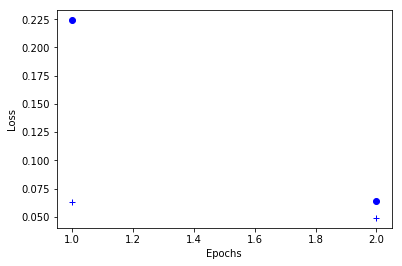

In [19]:
plt.plot(epochs, loss_values, 'bo')
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

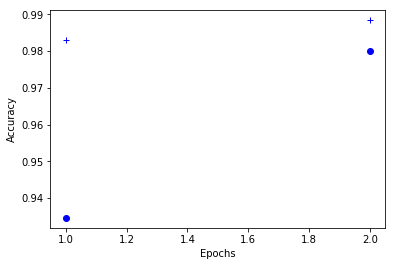

In [20]:
plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### Prediction

We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

In [21]:
images = data.test.images[0:9]

These are the true class-number for those images. This is only used when plotting the images.

In [22]:
cls_true = data.test.cls[0:9]

Get the predicted classes as One-Hot encoded arrays.

In [23]:
y_pred = model.predict(x=images)

Get the predicted classes as integers.

In [24]:
cls_pred = np.argmax(y_pred,axis=1)

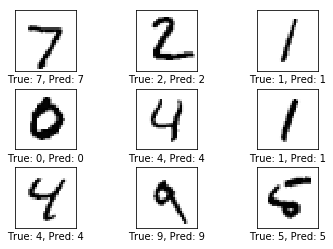

In [26]:
plot_images(images=images,
            img_shape=img_shape,
            cls_true=cls_true,
            cls_pred=cls_pred)

### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [27]:
y_pred = model.predict(x=data.test.images)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [28]:
cls_pred = np.argmax(y_pred,axis=1)

Plot some of the mis-classified images.

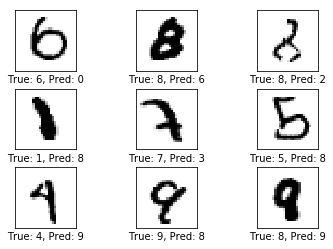

In [30]:
plot_example_errors(images, cls_true, img_shape, cls_pred, data)

## Visualization of Layer Weights and Outputs

### Helper-function for plotting convolutional weights

In [31]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Get Layers

Keras has a simple way of listing the layers in the model.

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0         
__________

We count the indices to get the layers we want.

The input-layer has index 0.

In [33]:
layer_input = model.layers[0]

The first convolutional layer has index 2.

In [34]:
layer_conv1 = model.layers[2]
layer_conv1

The second convolutional layer has index 4.

In [35]:
layer_conv2 = model.layers[4]

### Convolutional Weights

Now that we have the layers we can easily get their weights.

In [36]:
weights_conv1 = layer_conv1.get_weights()[0]

This gives us a 4-rank tensor.

In [37]:
weights_conv1.shape

(5, 5, 1, 16)

Plot the weights using the helper-function from above.

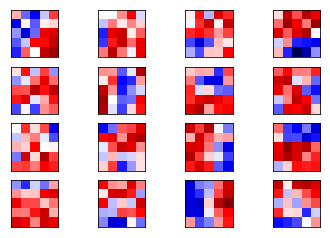

In [38]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

We can also get the weights for the second convolutional layer and plot them.

In [39]:
weights_conv2 = layer_conv2.get_weights()[0]

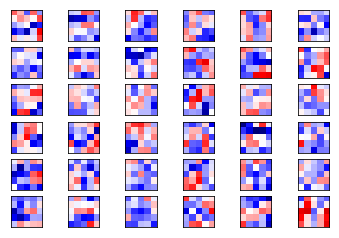

In [40]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

### Helper-function for plotting the output of a convolutional layer

In [41]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Image

Helper-function for plotting a single image.

In [42]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

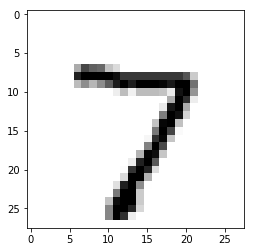

In [43]:
image1 = data.test.images[0]
plot_image(image1)

### Output of Convolutional Layer

There are different ways of getting the output of a layer in a Keras model. This method uses a so-called K-function which turns a part of the Keras model into a function.

In [44]:
from tensorflow.python.keras import backend as K

In [45]:
output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])

We can then call this function with the input image. Note that the image is wrapped in two lists because the function expects an array of that dimensionality. Likewise, the function returns an array with one more dimensionality than we want so we just take the first element.

In [46]:
layer_output1 = output_conv1([[image1]])[0]
layer_output1.shape

(1, 28, 28, 16)

We can then plot the output of all 16 channels of the convolutional layer.

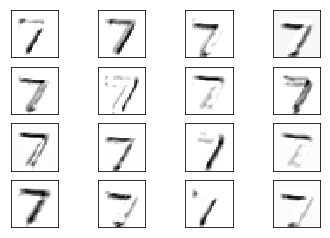

In [47]:
plot_conv_output(values=layer_output1)

In [ ]:
plot_conv_output(values=layer_output2)